Exploration 3의 두번째 소주제로 넘어왔다.
여기에서는, 기존의 소스코드를 조금 더 발전시키는 것을 목적으로 한다.
그 일환이 되는 것은 주로 hyperparameter tuning이라고 생각되는데, 데이터 전처리도 추가적으로 들어가는지 잘 모르겠다.
살펴보게 되겠지.

이번에도 각 subsection의 최상단에 comment를 달 생각이고, 노드의 셀들을 모두 돌릴 예정이다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

print('얍💢')

얍💢


## 3.9. (1) 다시 한 번, 내 입맛대로 데이터 준비하기

- 03.09-12와 비슷하게 데이터를 불러온다.
다만, 이번에는 `'train.csv'`라는 파일을 `train`이라는 객체로 불러오고, `'test.csv'`라는 파일을 `test`라는 객체로 불러온다.
- `'date'`열의 값을 최초 6자리만 잘라내는 것은 기존과 동일하나, data type을 `int`로 바꾸었다.
이것은 중요하다.
그러니까, 03.09-12에서는 data type이 `str`이었던 것이다.
 03.09-12에서 사용한 모델이 어떤 모델인지 정확히 모르겠어서 정확하게 말할 수는 없겠지만, 기존까지는 '201410'와 같은 데이터를 숫자가 아닌 문자열로 판단하고 있었다.
이것을 숫자로 인식하는 것은 상당한 도움이 될 수 있겠다.
- `train`에서 label에 해당하는 `pd.Series`는 따로 떼어내서 `y`에 할당한다.
또한, `train`의 label 열을 없애니, `train`과 `test`의 feature의 개수가 20개로 같아졌다.
`train`과 `test` 모두에서 `'id'` 열을 제거한다.
- 이로서 기본적인 데이터 전처리가 끝났다.
앞으로 수치적인 전처리를 조금 더 해야겠지만, 여하튼 아래에 명시된 shape과 dtype은 변하지 않을 것이다.

|객체명   |설명                     |shape      |dtype|
|:-:      |:-:                      |:-:        |:-:|
|`train`  |training dataset, feature|(15035, 19)|`pd.DataFrame`|
|`test`   |test dataset, feature    |(6468, 19) |`pd.DataFrame`|
|`y`      |training dataset, label  |(15035, )  |`pd.Series`|
|(없음)   |test dataset, label      |           ||

- 수치적인 전처리의 첫단계를 진행한 후 다음 subsection으로 넘어가게 된다.
 여기서 말하는 첫단계란, `y`에 $y=\log(1+x)$를 적용하는 것이다.
 03.09-12에서는 feature들에만 $y=\log(1+x)$를 적용했었는데 이번에는 `y`에 적용시킨 것이다.
이때 상당히 신중해야 한다.
로그변환을 적용시킨 `y`는 학습 시에 사용되게 된다.
그러면, 학습된 모델은 그 *로그변환이 적용되었다고 가정된* 예측치 `y_pred_logscaled`(가제)를 출력하게 된다.
하지만 우리가 원하는 것은 *로그변환이 적용되기 전 형식의* 예측치이므로 `np.expm1(y_pred_logscaled)`와 같은 값이 최종적인 예측치가 될 것이다.

- 여기에서 전처리과정은 끝난다.
03.09-12에서 여러 feature에 대한 전처리과정이 있었던 것과 상반된다.
그러니까, 실제 submit project에서는 feature에 대한 logscale 전처리과정이 필요할 것이다.

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


In [6]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
print(train.shape)
print(test.shape)

(15035, 20)
(6468, 20)


In [8]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

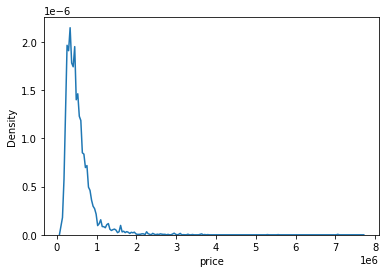

In [11]:
sns.kdeplot(data = y, bw_adjust = 0.1)

In [12]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

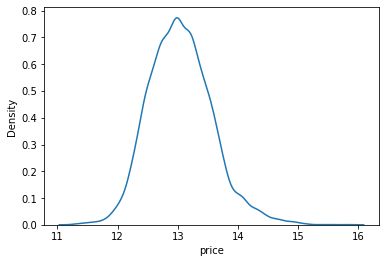

In [13]:
sns.kdeplot(y)
plt.show()

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [15]:
print(type(train))
print(type(test))
print(type(y))
print(train.shape)
print(test.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(15035, 19)
(6468, 19)
(15035,)


## 3.10. (2) 다양한 실험을 위해 함수로 만들어 쓰자

- 이 subsection은 03.04-08에서 '(4) 모델설계'에 해당하는 부분이다.
- 03.04-08과 다른 주요한 점은, 제목에서 말하듯 이 subsection의 내용들을 압축해 하나의 함수로 치환했다는 점이다.
이번 노드에서 중요한 것은 hyperparameter tuning을 통해 모델을 개선시켜나가는 것이기 때문에, 이외의 과정들을 일원화시켜서 한번에 실행시킬 수 있도록 한 것이다.
- 03.04-08과 다른 점들 중 세부적인 사항들은 지금부터 열거해보겠다.
  - 가장 먼저, ensemble하는 모델의 개수가 3개 (gboost, xgboost, lightgbm)에서 4개 (rdforest 추가)로 늘어났다는 점이 있다.
  - 또한, 03.04-08에서는 K-fold (5-fold) cross validation의 형식으로 ensemble 모델의 성능을 측정했다.
  그런데 이번에는 cross validation 대신 그냥 `train_test_split`을 사용하였다.
  이것은, train/validation/test split에 해당된다.
  그러니까 `test` 객체는 그대로 test set에 대응되지만, `train`과 `y` 객체는 그것을 각각 둘로 나누어 `X_train`, `X_test`과 `y_train`, `y_test`로 나누었다.
  이때, `X_train`과 `y_train`은 training set에 대응되고 `X_test`와 `y_test`는 validation set에 해당된다.
  - 지금의 이 코드는 그다지 중요한 코드가 아니다.
  그냥, `models`, `train`, `y`가 주어졌을 때, 'RMSE'를 출력하는 함수를 하나 만들었을 뿐이다.
  다음 subsection에서는 `GridSearchCV`를 사용하게 되는데 이때에는 train/validation/test split이 아니라, (다시) cross validation을 사용하게 되며, 따라서 현재의 이 코드는 여기에서만 쓰일 뿐이다.
  다만 다음 subsection에서는 ensemble을 쓰는 것이 아닌, 단일한 모델을 사용하고 있으므로 여기의 코드를 조금 변형해서 다음 subsection의 코드에 적용시켜야 할 것이다.
  
<!--   |03.04-08| →|03.09-12||| -->
  |객체명  |   |객체명   |설명                       |shape|
  |:-:     |:-:|:-:      |:-:                        |:-:|
  |`train` | →|`X_train`|training dataset, feature  |(12028, 19)|
  |`train` | →|`X_test` |validation dataset, feature|(3007, 19) |
  |`test`  |   |         |test dataset. feature      |(6468, 19) |
  |`y`     | →|`y_train`|training dataset, label    |(12028, )  | 
  |`y`     | →|`y_test` |validation dataset, label  |(3007, )   |
  |(없음)  |   |         |test dataset, label        || 
  
- 그밖에, 세부적인 코드가 조금 바뀌었다는 점이 있는데, 그렇게까지 특기할 만한 사항이 아니므로 굳이 언급하지 않겠다.

In [16]:
15035*0.8

12028.0

In [17]:
15035-12028

3007

In [18]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [19]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2022        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [20]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [21]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 130361.23368538941,
 'XGBRegressor': 127865.51864932069,
 'LGBMRegressor': 120099.06723661404,
 'RandomForestRegressor': 135139.59142571784}

In [22]:
random_state=2020
# a simplified version of previous cell
def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE',ascending = False)
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128359.114616
RandomForestRegressor,125641.220557
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


## 3.11. (3) 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

- hyperparameter tuning을 진행한다.
- 두 개의 hyperparameter만을 고려하고 있고, 각각의 hyperparameter에 대해서 두 개의 값들만 고려하고 있다.
세부적인 사항을 써보면 다음과 같다.
- `param_grid`에 `dict` 형태로 hyperparameter 이름과 그 값의 candidates를 `list` 형태로 적는다.
- `model`은 단일한 모델 `LGBMRegressor`로 설정되어 있는데, 이것을 ensemble 모델로 변환하면 더 나아질 것이다.
- `GridSearchCV`를 시행한다.
이 subsection의 핵심코드이다.
인자로서 다음의 6가지를 넣는다.
 - `model`
 - `param_grid=param_grid`
 - `scoring='neg_mean_squared_error'`
 - `cv=5`
 - `verbose=1`
 - `n_jobs=5`
이 중 `model`, `scoring'`는 건드릴 수 없다.
`verbose`는 건드리는 것이 전체 모델의 성능에 영향을 주지 않는다.
`n_jobs`는 `-1`로 바꿔보면 계산속도가 빨라질지도 모르겠다.
건드려볼 수 있는 것은 `model`, `param_grid`이다.
- 주요 결과를 요약해 `pd.DataFrame` 객체인 `results`로 저장하고 보여준다.
- 모든 결과를 `my_GridSearch`에 요약해 일원화한다.
개선시켜야 한다면 이 코드를 개선시키는 것이 맞을텐데,
이중 `model`을 인자로 받지 않고 `models`를 인자로 받을 수 있도록 해야 할 것이다.

In [23]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [24]:
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [25]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [26]:
grid_model.cv_results_

{'mean_fit_time': array([0.56775341, 0.77186303, 1.3682622 , 2.16028228]),
 'std_fit_time': array([0.03398066, 0.02368444, 0.06024762, 0.13449295]),
 'mean_score_time': array([0.04582787, 0.05187764, 0.09607368, 0.12079377]),
 'std_score_time': array([0.01575915, 0.01366466, 0.02954531, 0.03401748]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [27]:
results = pd.DataFrame(grid_model.cv_results_['params'])
results['score'] = grid_model.cv_results_['mean_test_score']
results['RMSLE'] = np.sqrt(-1 * results['score'])
results.sort_values(by = 'RMSLE')

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [28]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

## 3.12. (4) 제출하는 것도, 빠르고 깔끔하게!

- `my_GridSearch` 함수를 적용하여 괜찮은 hyperparameter들의 조합을 추출한다.
이것을 통해 하나의 모델을 설정한다.
- 이 모델의 hyperparameter 조합인 (10, 100)과 그때의 성능인 `(0.164399)`을 기억해두었다가, 나중에 파일명을 저장할 때 써먹는다.
이값들 또한 객체로 두어 저장하는 것도 한가지 방안이 될 수 있을 것 같다.
- 모델을 설정하고 나면, 이 모델과 데이터들을 가지고 submission 파일을 저장하는 절차를 한번에 할 수 있는 함수 `save_submission`를 정의한다.
이 함수의 묘미는, 파일명에 모델 이름과 그 결과값을 표시할 수 있다는 점이다.

In [29]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [30]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [31]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [32]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [33]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [35]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))


In [36]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!
